In [98]:
#Importimg relevant libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [99]:
#Reading in CSV data

five = pd.read_csv('Lessthan_5_victim_count.csv')
fourteen = pd.read_csv('5_to_14_victim_count.csv')
thirty = pd.read_csv('15_to_30_victim_count.csv')
highest = pd.read_csv('Highest_victim_count.csv')

In [100]:
#Combining all 4 data files and creating a complete csv file
df = pd.concat([five,fourteen,thirty,highest],ignore_index=True)
df.to_csv('complete_sk_list.csv')

In [101]:
#Reading in complete data, setting index to name column
df = pd.read_csv('complete_sk_list.csv',index_col=0)
df.head()

,Name,Country,Years active,Proven victims,Possible victims,Notes
0,Charlie Brandt,United States,1971 to 2004,4,29,Committed suicide by hanging after murdering h...
1,Robert Black,United Kingdom\r\nIreland (suspected)\r\nWest ...,1981 to 1986,4,18+,"Convicted of kidnapping, raping and murdering ..."
2,Max Gufler,Austria,1946 to 1958,4,18,"Poisoned and drowned four women, but suspected..."
3,Ernesto Picchioni,Italy,1949 and earlier,4,16,Murdered people who approached his home; died ...
4,Baekuni,Indonesia,1993 to 2010,4,14,Pedophile who raped and killed young boys; ini...


Data cleaning

In [102]:
#From the output, we can see that the 'Possible victims' column is missing some values
#We will fix this later
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305 entries, 0 to 304
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Name              305 non-null    object
 1   Country           305 non-null    object
 2   Years active      305 non-null    object
 3   Proven victims    305 non-null    object
 4   Possible victims  237 non-null    object
 5   Notes             305 non-null    object
dtypes: object(6)
memory usage: 16.7+ KB


In [103]:
#filling na values of possible victims with proven victims
df.loc[df['Possible victims'].isna(),'Possible victims']=df['Proven victims']
df=df.fillna(value=df['Proven victims'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305 entries, 0 to 304
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Name              305 non-null    object
 1   Country           305 non-null    object
 2   Years active      305 non-null    object
 3   Proven victims    305 non-null    object
 4   Possible victims  305 non-null    object
 5   Notes             305 non-null    object
dtypes: object(6)
memory usage: 24.8+ KB


In [104]:
#filling "unknown" possible victims with proven victims
df.loc[df['Possible victims'].isin(['Unknown', '-']), 'Possible victims'] = df['Proven victims']

In [ ]:
#fixing possible victims, proven victims columns to numeric values
df = df.apply(lambda x: x.apply(str) if x.dtype == 'object' else x)
df = df.apply(lambda x: x.str.rstrip('+') if x.dtype == 'object' else x)
df = df.apply(lambda x: x.str.rstrip('?') if x.dtype == 'object' else x)
df = df.apply(lambda x: x.str.lstrip('~') if x.dtype == 'object' else x)
df['Proven victims'].value_counts(dropna=False)

In [106]:
#in cases where there is a range of possible victims\ proven victims - we chose the upper value
# Let's replace all the ranges with both types of hyphens with the max value
df['Possible victims'] = [str(x).split('-')[-1] for x in df['Possible victims']]
df['Possible victims'] = [str(x).split('–')[-1] for x in df['Possible victims']]
# Let's replace all the ranges with the max value
df['Proven victims'] = [str(x).split('–')[-1] for x in df['Proven victims']]

In [107]:
#handling years active field
df['Years active'] = df['Years active'].str.replace(' and earlier', '', regex = False)
df['Years active'] = df['Years active'].str.replace(' to present', '', regex = False)
df['Years active'] = df['Years active'].str.replace('30 June 1983', '1983', regex = False)
df['Years active'] = df['Years active'].str.replace(' to 23 July 1983', '', regex = False)
df['Years active'] = df['Years active'].str.replace('s', '', regex = False)
df['Years active']= df['Years active'].str.replace('?', '', regex = False)
df['Years active'] = df['Years active'].str.replace('c.', '', regex = False)
df['Years active']= df['Years active'].str.replace('late ', '', regex = False)


In [108]:
#Creating columns to get start and end year of the serial killer
# Create new cols for To Date and From Date
df['From year'] = np.nan
df['To year'] = np.nan
df[['From year','To year']] = df['Years active'].str.split('to',expand=True)


In [109]:
# check how many missing values in the To year col
df['To year'].isna().sum()

44

In [110]:
# Replace with the corresponding values from the From_Date col
df['To year'].fillna(df['From year'],inplace=True)
df['To year'].isna().sum()

0

In [111]:
# get rid of the now redundant Years_active col
df.drop('Years active', axis=1, inplace=True)
df.columns

Index(['Name', 'Country', 'Proven victims', 'Possible victims', 'Notes',
       'From year', 'To year'],
      dtype='object')

In [112]:
# Convert "From year" , "To year" columns to integer data type
df["From year"] = df["From year"].astype(pd.Int64Dtype())
df["To year"] = df["To year"].astype(pd.Int64Dtype())

In [113]:
# Create new cols for number of active years
df['Active Years'] = df['To year'].values - df['From year'].values
# Above op may result in some zero values if the to and from years are same. In such case value should be 1
df['Active Years'].replace({0:1}, inplace=True)

In [ ]:
# Convert "Proven victims" , "Possible victims" columns to integer data type
df["Proven victims"] = df["Proven victims"].astype(pd.Int64Dtype())
df["Possible victims"] = df["Possible victims"].astype(pd.Int64Dtype())

In [115]:
#data cleaning country names
#For killers who were active in multiple countries - assigning first country they were active in
df.loc[df['Country']=='Soviet Union\r\nRussia', "Country"] = "Russia"
df.loc[df['Country']=='Spain\r\nFrance (claimed)\r\nItaly (claimed)', "Country"] = "Spain"
df.loc[df['Country']=='China\r\nJapan', "Country"] = "China"
df.loc[df['Country']=='Switzerland\r\nFrance\r\nUnited States\r\nYugoslavia (suspected)\r\nItaly (suspected)', "Country"] = "Switzerland"
df.loc[df['Country']=='United States\r\n Portuguese Angola', "Country"] = "United States"
df.loc[df['Country']=='Canada\r\nUnited States', "Country"] = "United States"
df.loc[df['Country']=='German Empire\r\nGermany', "Country"] = "Germany"
df.loc[df['Country']=='East Germany\r\nGermany\r\nFrance\r\nSpain\r\nCzech Republic (suspected)\r\nItaly (suspected)', "Country"] = "Germany"
df.loc[df['Country']=='United Kingdom\r\nIreland (suspected)\r\nWest Germany (suspected)\r\nNetherlands (suspected)\r\nFrance (suspected)', "Country"] = "United Kingdom"
df.loc[df['Country']=='Austria\r\nUnited States\r\nCzechoslovakia', "Country"] = "Austria"
df.loc[df['Country']=='Thailand\r\nNepal\r\nIndia\r\nMalaysia', "Country"] = "Thailand"
df.loc[df['Country']=='Allied-occupied Germany\r\nWest Germany', "Country"] = "Germany"
df.loc[df['Country']=='Soviet Union\r\nRussia\r\nUkraine', "Country"] = "Russia"
df.loc[df['Country']=='Austria-Hungary', "Country"] = "Austria"
df.loc[df['Country']=='France\r\nGermany (suspected)\r\nSwitzerland (suspected)', "Country"] = "France"
df.loc[df['Country']=='United States\r\nCanada', "Country"] = "United States"
df.loc[df['Country']=='Soviet Union\r\nRussia\r\nTajikistan', "Country"] = "Russia"
df.loc[df['Country']=='Ottoman Empire\r\n Iraq\r\n Iran', "Country"] = "Iraq"
df.loc[df['Country']=='Kingdom of Romania\r\nYugoslavia\r\nHungary (alleged)', "Country"] = "Romania"
df.loc[df['Country']=='Colombia\r\nEcuador\r\nBrazil (alleged)', "Country"] = "Colombia"
df.loc[df['Country']=='Colombia\r\nEcuador\r\nVenezuela', "Country"] = "Colombia"
df.loc[df['Country']=='United States\r\nMexico', "Country"] = "United States"
df.loc[df['Country']=='France\r\nBelgium', "Country"] = "France"
df.loc[df['Country']=='Colombia\r\nPeru\r\nEcuador', "Country"] = "Colombia"
df.loc[df['Country']=='Soviet Union', "Country"] = "Russia"
df.loc[df['Country']=='Soviet Union\r\nUkraine', "Country"] = "Russia"


Examining countries with the highest count of Serial killers 

In [116]:

#creating top 5 countries df
country_killer = df.groupby('Country',as_index=False)['Name'].count().sort_values(
    'Name',ascending = False).reset_index(col_level = 1).head(5)
country_killer.drop('index',axis=1,inplace=True)
country_killer.rename(columns={'Name':"Number of Killers"},inplace=True)
country_killer
#The US (top country) has double the number of Serial Killers that the 2nd highest country (Russia) has

,Country,Number of Killers
0,United States,96
1,Russia,42
2,South Africa,19
3,United Kingdom,13
4,India,10


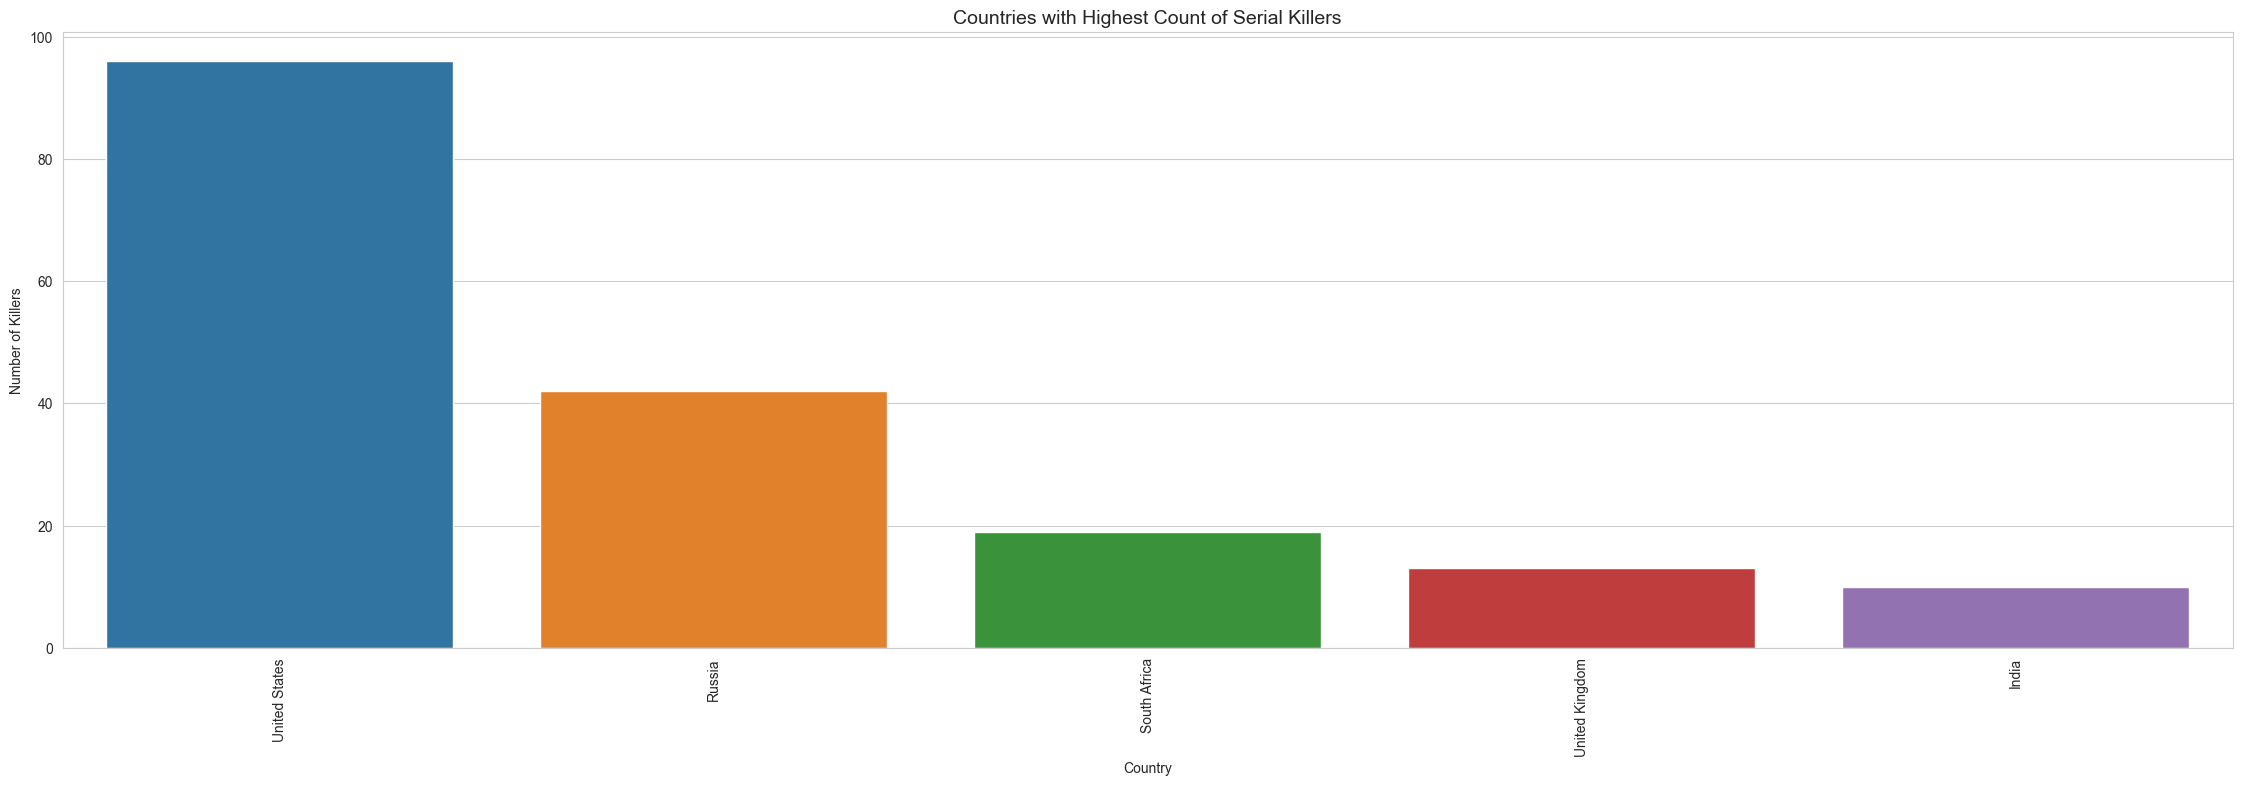

In [120]:
#plotting SK countries - top 5
plt.figure(figsize=(28,8))
g = sns.barplot(x = country_killer['Country'], y = country_killer['Number of Killers'], data= country_killer)
g.set(ylabel='Number of Killers')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Countries with Highest Count of Serial Killers',fontsize =14)
plt.show()


Examining Serial Killer Activity Over the Years

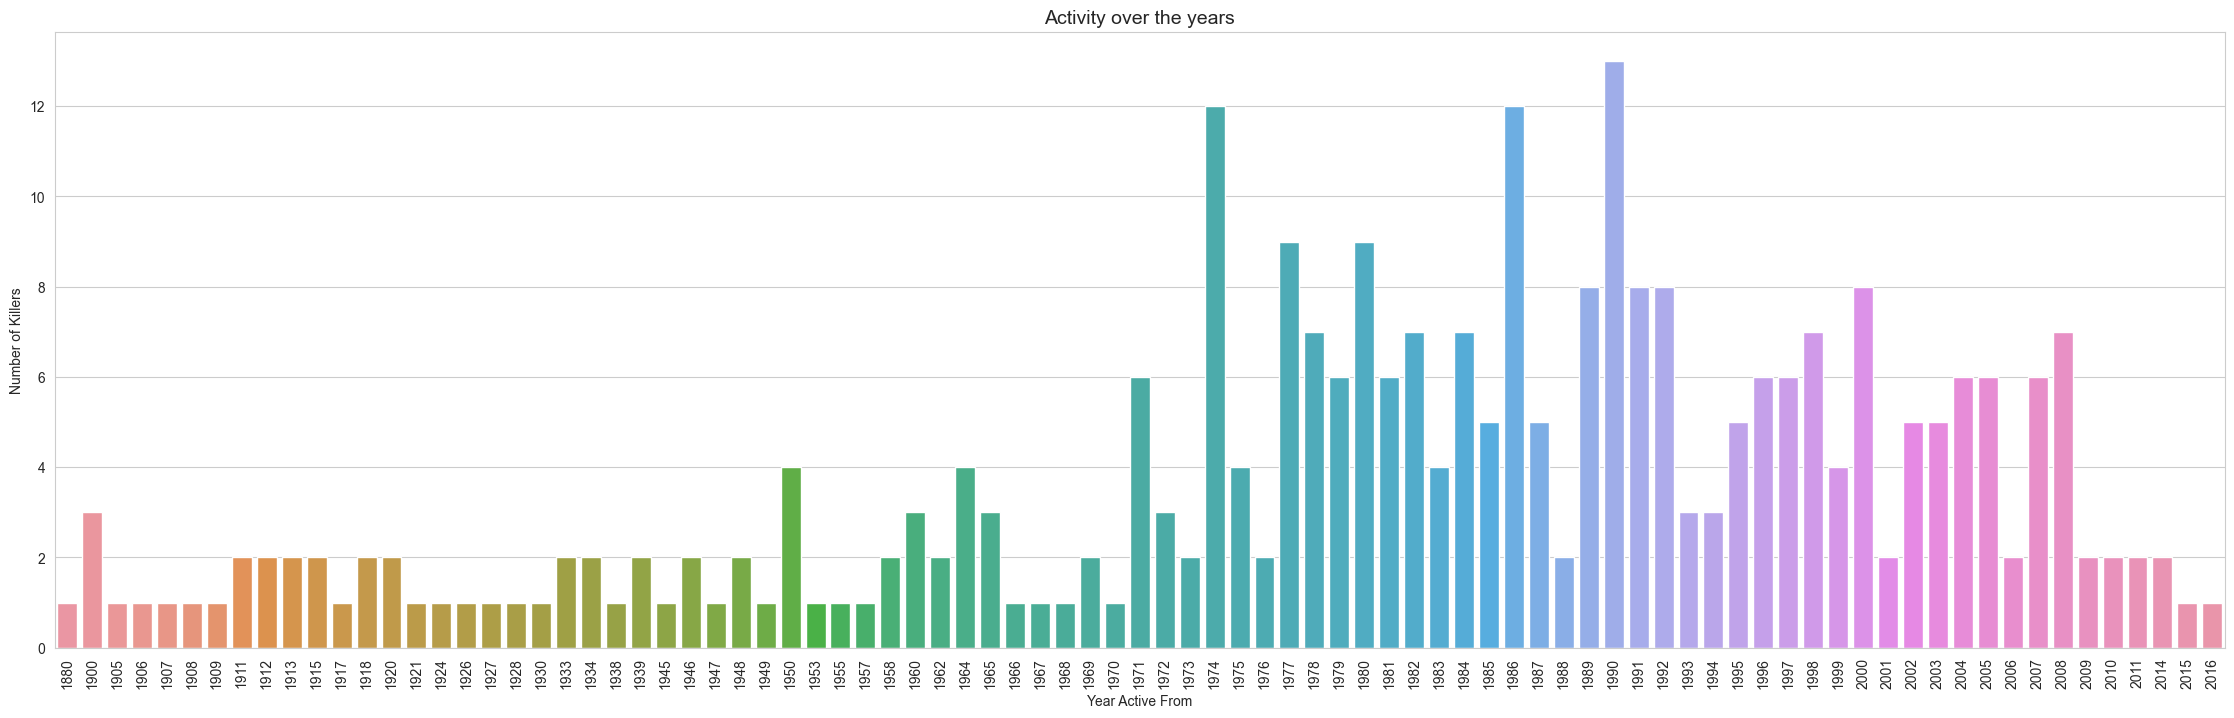

In [94]:
# Plot to see pattern over the years - Start year
plt.figure(figsize=(28,8))
g = sns.countplot(data = df, x = "From year")
g.set(xlabel = 'Year Active From', ylabel = 'Number of Killers')
g.set_xticklabels(g.get_xticklabels(), rotation = 90)
g.set_title('Activity over the years',fontsize =14)
plt.show()
#We see that the highest number of  Serial Killers started killing in 1990 

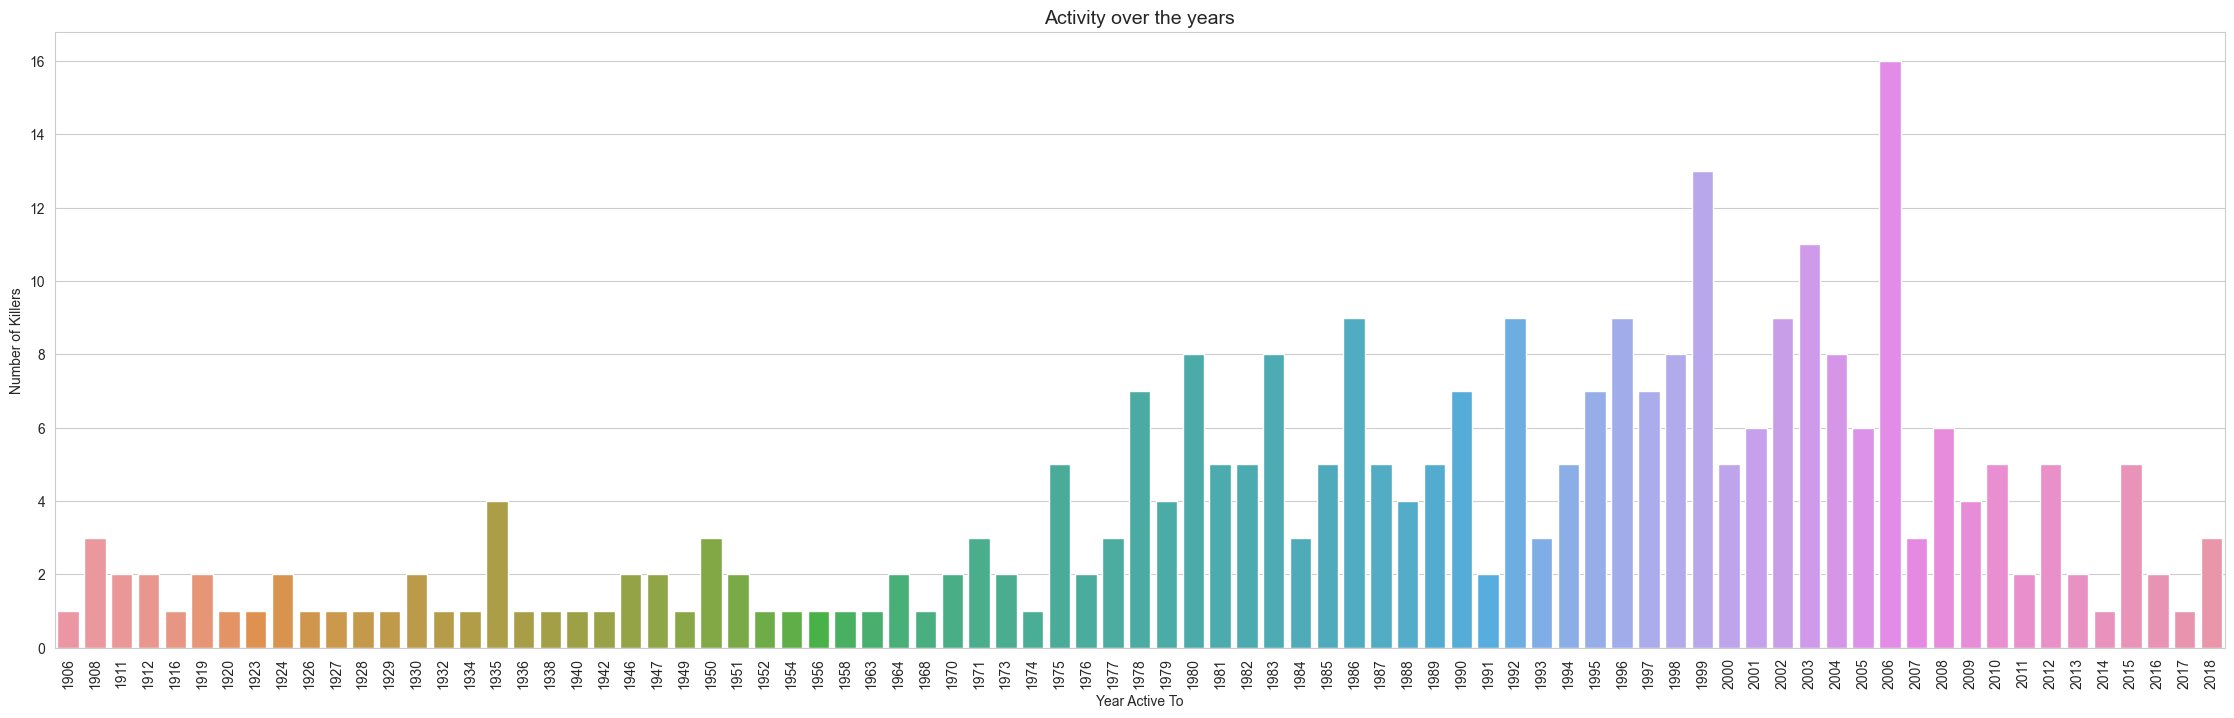

In [97]:
# Plot to see pattern over the years - End year
plt.figure(figsize=(28,8))
g = sns.countplot(data = df, x = "To year")
g.set(xlabel = 'Year Active To', ylabel = 'Number of Killers')
g.set_xticklabels(g.get_xticklabels(), rotation = 90)
g.set_title('Activity over the years',fontsize =14)
plt.show()
#We see that the highest number of  Serial Killers stopped killing in 1999 

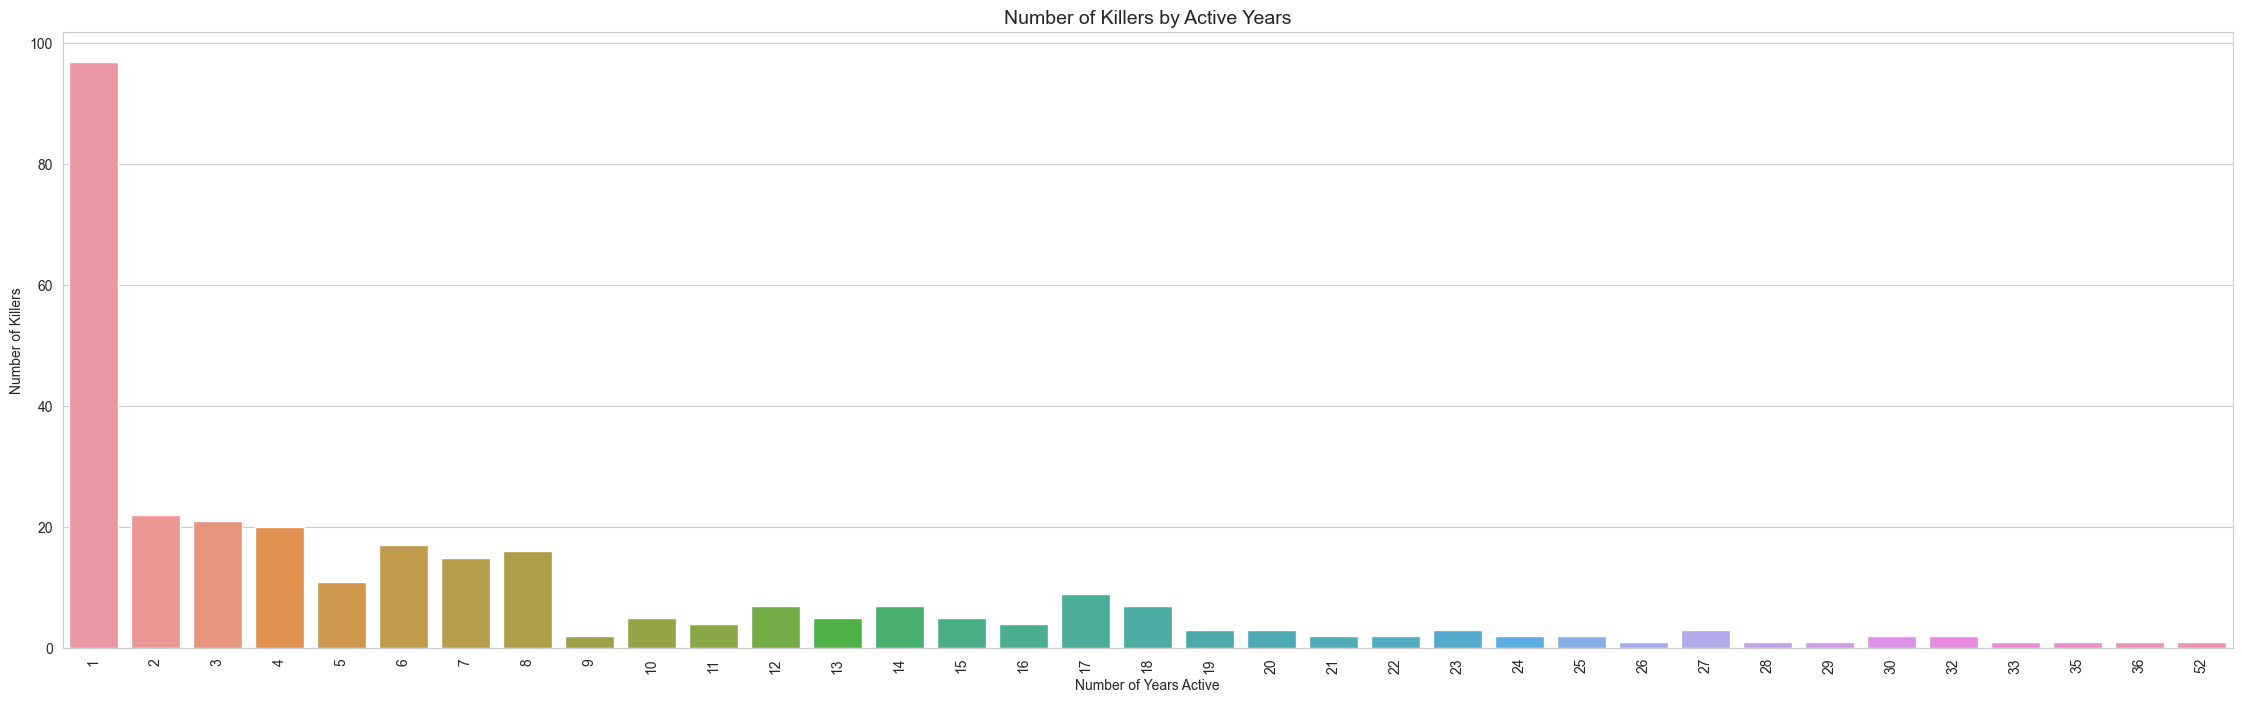

In [118]:
# Plot to see distribution of active years
plt.figure(figsize=(28,8))
g = sns.countplot(data = df, x = "Active Years")
g.set(xlabel = 'Number of Years Active', ylabel = 'Number of Killers')
g.set_xticklabels(g.get_xticklabels(), rotation = 90)
g.set_title('Number of Killers by Active Years',fontsize =14)
plt.show()
#We see that most killers were only active for 1 year

In [96]:
# Killers active the longest
top_active_df = df[['Name','Country','Active Years']].sort_values(by = 'Active Years', ascending=False).head(15)
top_active_df

,Name,Country,Active Years
185,John Floyd Thomas Jr.,United States,52
276,Pedro Rodrigues Filho,Brazil,36
279,Samuel Little,United States,35
0,Charlie Brandt,United States,33
255,Carroll Cole,United States,32
126,Volker Eckert,Germany,32
114,Dennis Rader,United States,30
160,Michael Wayne McGray,United States,30
66,Donald Henry Gaskins,United States,29
216,Francisco Guerrero Pérez,Mexico,28


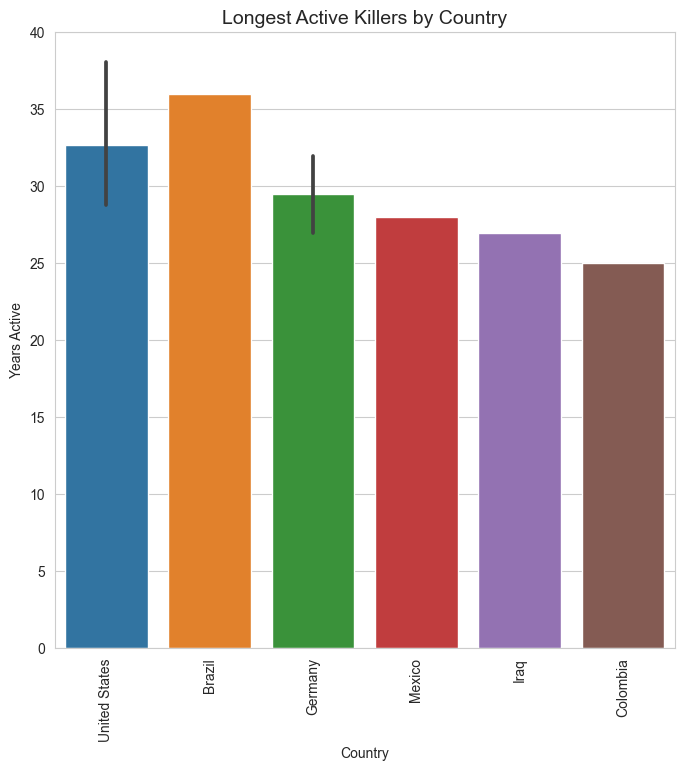

In [122]:
#plotting longest active killers by country
plt.figure(figsize=(8,8))
g = sns.barplot(x = top_active_df['Country'], y =top_active_df['Active Years'], data= country_killer)
g.set(ylabel='Years Active')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Longest Active Killers by Country',fontsize =14)
plt.show()

Distribution of number of victims

Text(0, 0.5, 'Number of killers')

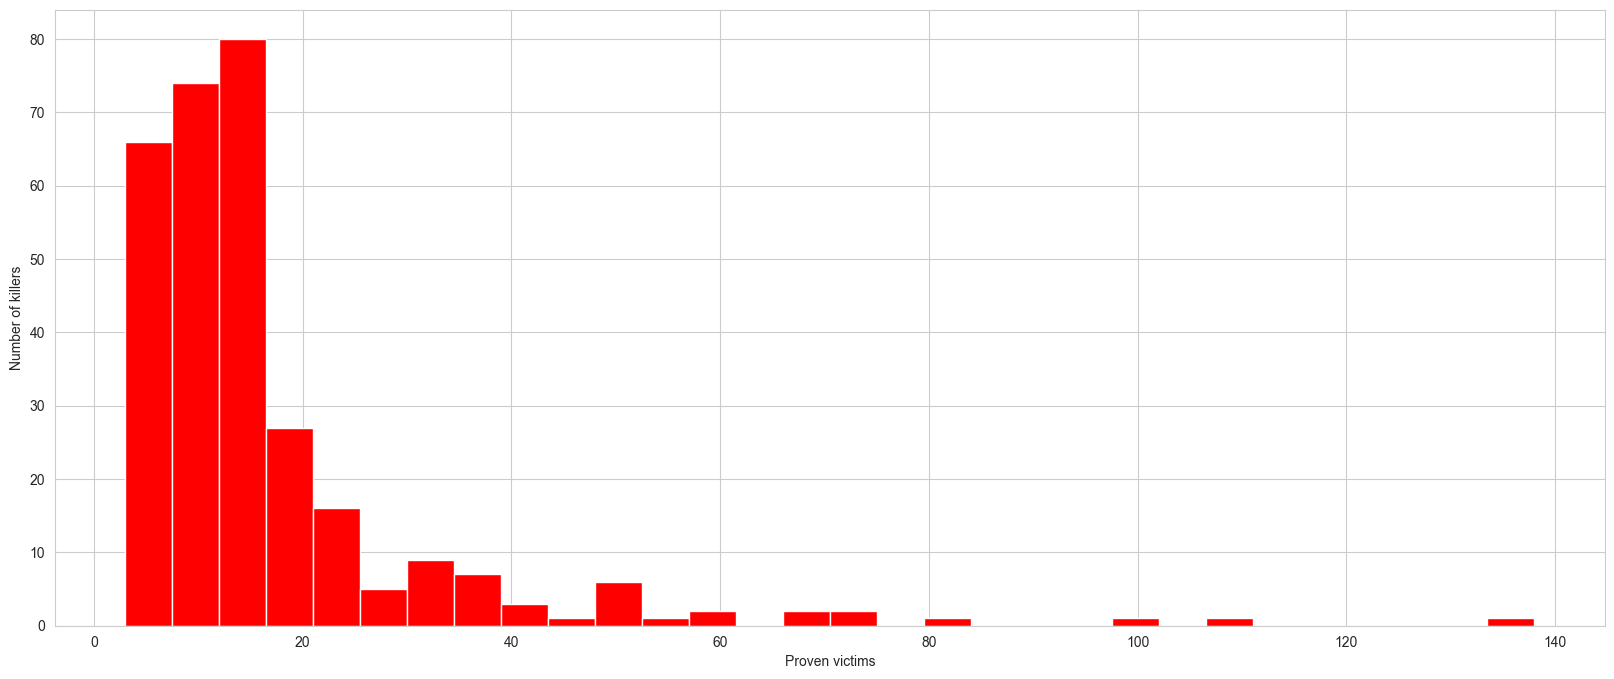

In [123]:

#Distribution of number of proven victims
plt.figure(figsize=(20,8))
sns.set_style('whitegrid')
df['Proven victims'].hist(bins=30,color='red')
plt.xlabel('Proven victims')
plt.ylabel('Number of killers')

Creating and analyzing sub data for US killers

Text(0, 0.5, 'Number of killers')

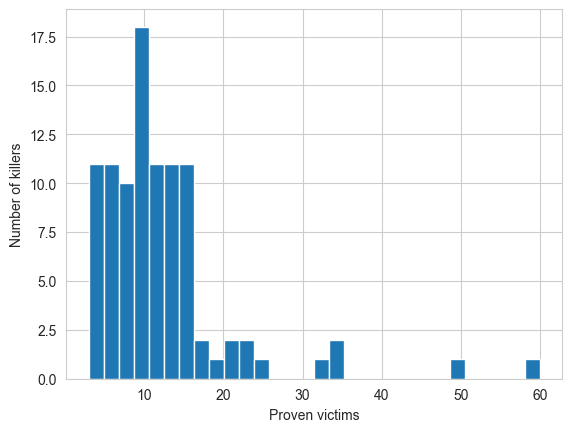

In [124]:
#Creating sub dataframe
df_us = df[df['Country']=="United States"]
#plotting histogram of proven victims
sns.set_style('whitegrid')
df_us['Proven victims'].hist(bins=30)
plt.xlabel('Proven victims')
plt.ylabel('Number of killers')

Geographical plotting

In [125]:
#creating list of countries and number of SK
country_killers = df.groupby('Country',as_index=False)['Name'].count().sort_values(
    'Name',ascending = False).reset_index(col_level = 1)
country_killers.drop('index',axis=1,inplace=True)
country_killers.rename(columns={'Name':"Number_of_Killers"},inplace=True)
country_killers

,Country,Number_of_Killers
0,United States,96
1,Russia,42
2,South Africa,19
3,United Kingdom,13
4,India,10
5,China,10
6,Brazil,8
7,France,8
8,Colombia,7
9,Italy,6


In [126]:
# generate country code  based on country name 
import pycountry 
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE
# create a column for code
# create a column for code 
country_killers['CODE']=alpha3code(country_killers.Country)
country_killers.head()

,Country,Number_of_Killers,CODE
0,United States,96,USA
1,Russia,42,None
2,South Africa,19,ZAF
3,United Kingdom,13,GBR
4,India,10,IND


In [127]:
#Importing relevant libraries
import geopandas
import mapclassify

In [128]:
# first let us merge geopandas data with our data
# 'naturalearth_lowres' is geopandas datasets so we can use it directly
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# rename the columns so that we can merge with our data
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
# then merge with our data 
merge=pd.merge(world,country_killers,on='CODE')
# last thing we need to do is - merge again with our location data which contains each country’s latitude and longitude
location=pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')
merge=merge.merge(location,on='name').sort_values(by='Number_of_Killers',ascending=False).reset_index()

C:\Users\naomi\AppData\Local\Temp\ipykernel_27584\1753892296.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


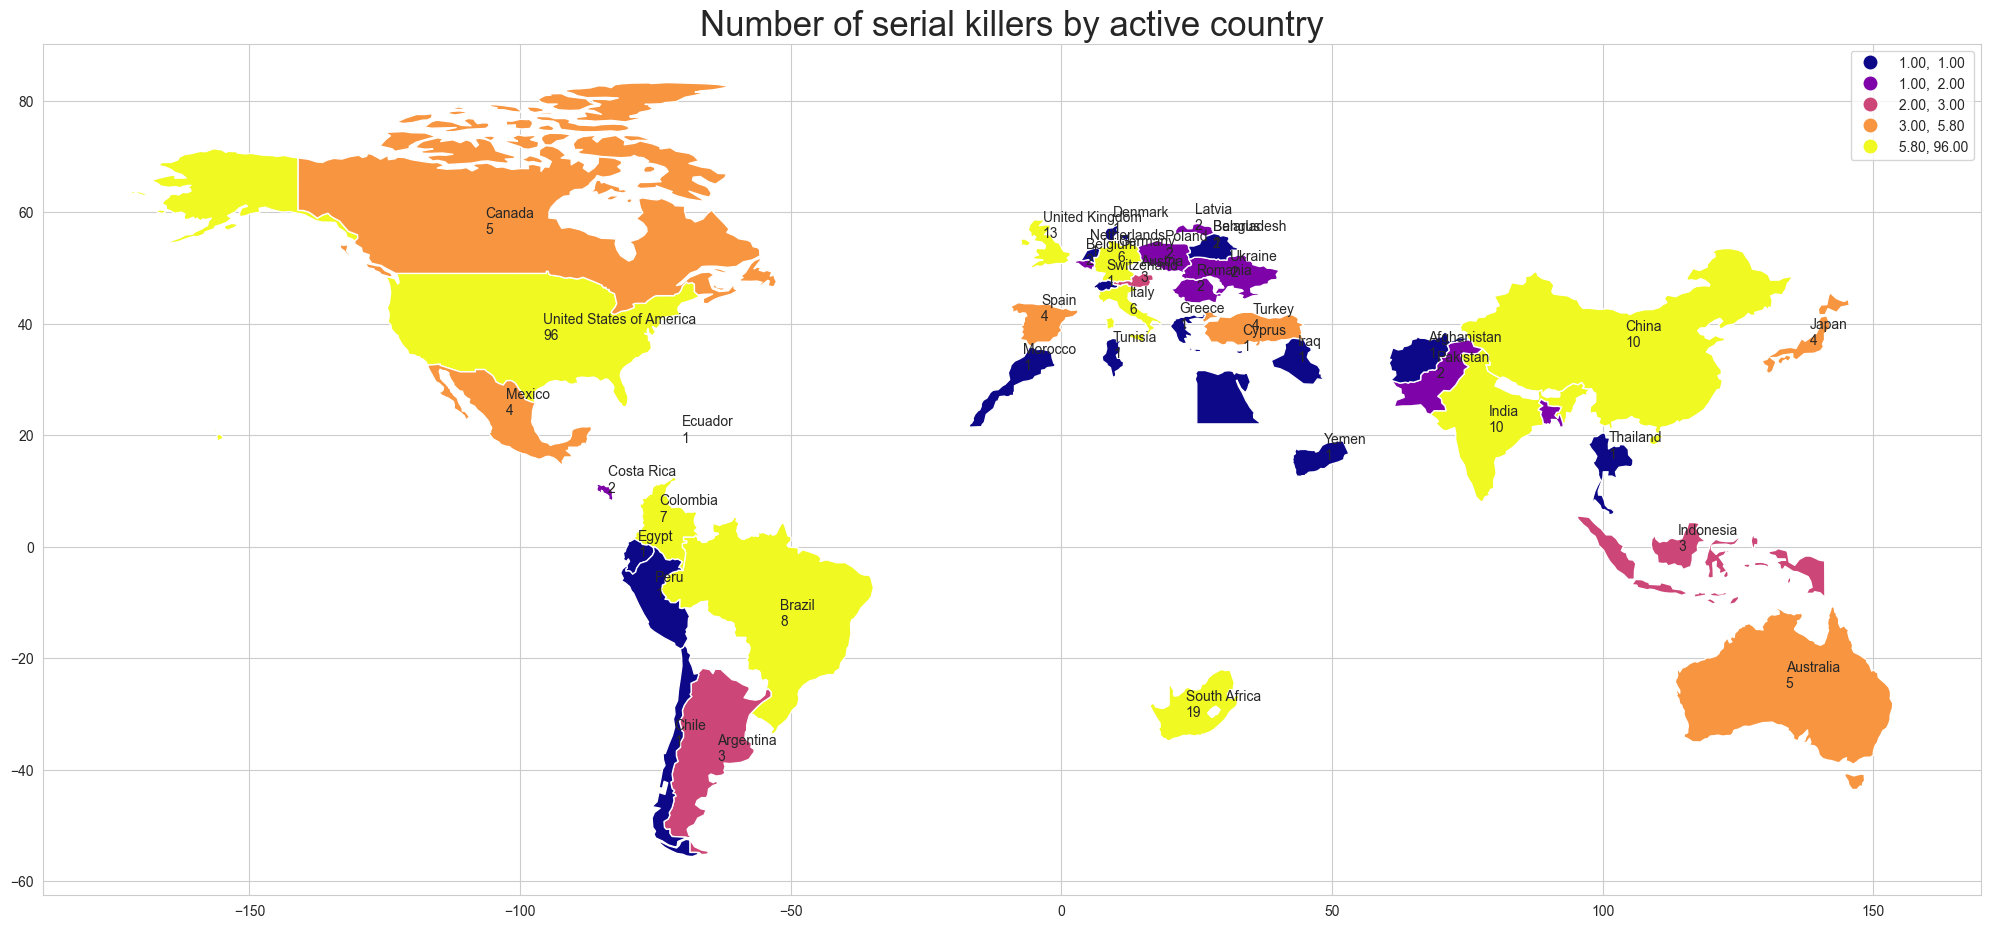

In [129]:
# serial killers world map
merge.plot(column='Number_of_Killers', scheme="quantiles",
           figsize=(25, 20),
           legend=True,cmap='plasma')
plt.title('Number of serial killers by active country',fontsize=25)
# add countries names and numbers 
for i in range(0,42):
    plt.text(float(merge.longitude[i]),float(merge.latitude[i]),"{}\n{}".format(merge.name[i],merge.Number_of_Killers[i]),size=10)
plt.show()

Examiining Name Field

In [133]:
df.info()
df['Name'] = df['Name'].astype('string')

<class 'pandas.core.frame.DataFrame'>
Index: 305 entries, 0 to 304
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              305 non-null    object 
 1   Country           305 non-null    object 
 2   Proven victims    305 non-null    Int64  
 3   Possible victims  305 non-null    Int64  
 4   Notes             305 non-null    object 
 5   From year         305 non-null    Int64  
 6   To year           305 non-null    Int64  
 7   Active Years      305 non-null    Int64  
 8   First_Name        0 non-null      float64
 9   Last_Name         0 non-null      float64
dtypes: Int64(5), float64(2), object(3)
memory usage: 35.8+ KB


In [144]:
# Split the 'Name' column into 'First Name' and 'Last Name' columns
df['First Name'] = df['Name'].str.split(' ').str[0]
df['Last Name'] = df['Name'].str.split(' ').str[1]

In [146]:
df.drop(columns=['First_Name','Last_Name','first_name','last_name'], inplace=True)
df.info()
#We see that there are two missing last names

<class 'pandas.core.frame.DataFrame'>
Index: 305 entries, 0 to 304
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Name              305 non-null    string
 1   Country           305 non-null    object
 2   Proven victims    305 non-null    Int64 
 3   Possible victims  305 non-null    Int64 
 4   Notes             305 non-null    object
 5   From year         305 non-null    Int64 
 6   To year           305 non-null    Int64 
 7   Active Years      305 non-null    Int64 
 8   First Name        305 non-null    object
 9   Last Name         303 non-null    object
dtypes: Int64(5), object(4), string(1)
memory usage: 35.8+ KB


In [153]:
#assign the last name to be the same as the first name in these oulier cases
df['Last Name'].fillna(df['First Name'],inplace=True)
df['Last Name'].isna().sum()


0

Adding a 'Predicted Sex' Field Based on First Name Column

In [155]:
#importing relevant library
import gender_guesser.detector as gender

In [ ]:
# Create an instance of the gender-guesser detector
d = gender.Detector()

# Function to predict sex based on first name
def predict_sex(first_name):
    return d.get_gender(first_name)

# Apply the predict_sex function to the 'First Name' column and create a new 'Sex' column
df['Sex'] = df['First Name'].apply(predict_sex)

# Map gender-guesser's outputs to standard categories (male, female, unknown)
sex_map = {
    'male': 'Male',
    'female': 'Female',
    'mostly_male': 'Male',
    'mostly_female': 'Female',
    'unknown': 'Unknown'
}

df['Sex'] = df['Sex'].map(sex_map)

In [157]:
df['Sex'].value_counts()


Sex
Male       234
Unknown     37
Female      23
Name: count, dtype: int64